In [109]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import csv
import re
import cv2
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import Huber
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse_met
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
from tensorflow.python.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (ModelCheckpoint,Callback,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,CSVLogger)
from imgaug import augmenters as iaa
import imgaug as ia
import warnings
warnings.filterwarnings("ignore")
dest_only_2019 = "/content/drive/My Drive/Colab Notebooks/BlindnessChallenge"


In [111]:
#Tensorflow callbacks
checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/BlindnessChallenge/working/ep_512_{epoch:02d}.hdf5", monitor="val_loss", verbose=1,
                             save_best_only=False, mode='min', save_weights_only=False)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto',
                                   min_delta=0.0001)
early = EarlyStopping(monitor="val_loss", mode="min", patience=9)
csv_logger = CSVLogger(filename=f'{dest_only_2019}/working/training_log_512.csv', separator=',', append=True)

In [112]:
#loading data
#new: augmentation param.
def loadDatasets_only_2019(dest_only_2019,augmentation=True):
    df_train = pd.read_csv(f"{dest_only_2019}/train.csv")
    if augmentation:
        train_aug = pd.read_csv(f"{dest_only_2019}/augmentacije.csv").iloc[:, 1:] #removing first column which is just the idx
        train_aug.columns = df_train.columns
        df_train = pd.concat([df_train,train_aug],axis=0,ignore_index=True)
    x,y = shuffle(df_train['id_code'],df_train['diagnosis'],random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=42) 
    return x_train, x_val, y_train, y_val

x_train, x_val, y_train, y_val = loadDatasets_only_2019(dest_only_2019)

In [113]:
from time import time
sigmaX = 50
a = x_train.sample(1)
path= f"{dest_only_2019}/train_images/{a.values[0]}.png"

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512, 512))
img=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)


In [114]:
def normalization_fn(img):
    img = np.divide(img,255)
    #print(f"{np.std(img[:,:,1])}")
    mean_value  = [0.485,0.456,0.406]
    std_value = [0.229,0.224,0.225]
    std_after = []
    mean_after = []
    for i in range(3):
        norm_tmp = np.subtract(img[:,:,i],np.mean(img[:,:,i]))
        std_mult = np.divide(std_value[i],np.std(img[:,:,i]))
        img[:,:,i] = np.add(mean_value[i],np.multiply(norm_tmp,std_mult))
        #mean_after.append(np.mean(img[:,:,i]))
        #std_after.append(np.std(img[:,:,i]))
    #print(f"{np.std(img[:,:,1])}")
    #print(norm_tmp.shape)
    return img

starting = time()
new_values_1 = normalization_fn(img)
ending = time()
tm = ending-starting
print(f"time:{tm}")

time:0.013131141662597656


In [122]:
def normalization_fn(img):
    img = np.divide(img,255)
    mean_value  = np.array([0.485,0.456,0.406])
    std_value = [0.229,0.224,0.225]
    #std_after = []
    #mean_after = []
    #img_channel_mean = np.mean(img,axis=(0,1)) #tuple(range(img.ndim-1))
    #norm_tmp = np.subtract(img,img_channel_mean)

    #img_channel_std = np.std(img,axis=(0,1))
    #std_mult = np.divide(std_value,img_channel_std)
    #multiplied_img = np.multiply(norm_tmp,std_mult)

    #return_img = np.add(multiplied_img,mean_value)
    norm_tmp = np.subtract(img, img.mean(axis=-1)[...,None])
    std_mul = np.divide(std_value ,img.std(axis=-1)[...,None])
    scaled_img = np.add(mean_value , norm_tmp * std_mul)
    return scaled_img

starting = time()
new_values_2 = normalization_fn(img)
ending = time()
tm = ending-starting
print(f"time:{tm}")

time:0.04342293739318848


In [ ]:
tuple(range(img.ndim-1))

(0, 1)

In [119]:
diff = np.array_equal(new_values_1, new_values_2)
print(diff)

False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


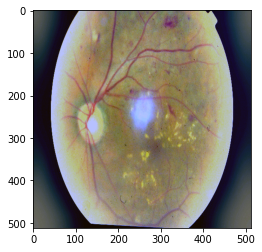

In [118]:
plt.imshow(new_values_1)

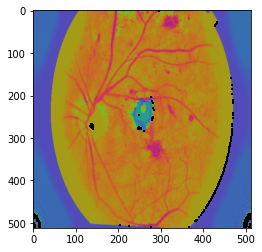

In [120]:
plt.imshow(new_values_2)

In [ ]:
a = np.random.random((512,512,3))
b = np.array([5000,1/5,1/1000])

In [ ]:
g = np.multiply(a,b)

In [ ]:
a.shape

(512, 512, 3)

In [ ]:
b.shape

(3,)

In [ ]:
g

array([[[4.30987307e+02, 4.46592509e-02, 2.57755627e-04],
        [4.63201982e+03, 3.52539237e-02, 5.74826569e-04],
        [4.85927661e+03, 1.40790558e-03, 2.83780761e-04],
        ...,
        [6.27750644e+02, 1.98144390e-01, 1.25405476e-04],
        [2.45146094e+03, 3.99147413e-02, 4.09981246e-04],
        [4.43537623e+03, 6.06528172e-02, 2.33790778e-04]],

       [[1.88577844e+03, 1.02805310e-01, 9.40798146e-04],
        [2.78738956e+03, 9.25772520e-02, 5.37282375e-04],
        [4.43156451e+03, 1.08929903e-01, 6.03760940e-07],
        ...,
        [1.63843291e+03, 1.33684491e-01, 1.69616135e-04],
        [4.80007338e+03, 1.35937074e-02, 3.29168752e-04],
        [2.90127150e+03, 5.08858722e-02, 7.17041370e-04]],

       [[1.55622485e+03, 9.70166997e-02, 7.41890531e-05],
        [2.64597672e+03, 8.15560158e-02, 6.55285684e-05],
        [3.99548975e+03, 1.02543936e-02, 1.43331860e-04],
        ...,
        [4.79670615e+03, 7.62434045e-02, 6.81501957e-04],
        [2.27807418e+03, 1.27

(0, 1)